PearsonRResult(statistic=0.8616954349277122, pvalue=6.000851784581014e-11)


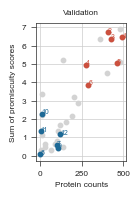

In [15]:
import pandas as pd
import collections
import numpy as np
import os
import stylia
from stylia import TWO_COLUMNS_WIDTH
from stylia import NamedColors

sel_fids = ["V0049", "V0157", "V0081", "V0480", "V0302", "V0053", "V4856", "V0005", "V5335", "V5151", "V0019", "V0022"]

df = pd.read_csv("../data/enamine_stock_miniautoml_predictions.tsv", sep="\t")
cols = ["catalog_id", "fid", "original_validation", "smiles"] + ["cLogP"] + [x for x in list(df.columns) if x.startswith("promiscuity")]
df = df[cols]

frag_ids = []
for fid in df["fid"].tolist():
    if str(fid) == "nan":
        frag_ids += [np.nan]
    else:
        frag_id = fid.split("-")[1]
        if len(frag_id) == 5:
            frag_ids += [frag_id]
        else:
            if frag_id == "V059":
                frag_id = "V0081"
            elif frag_id == "V060":
                frag_id = "V0157"
            elif frag_id == "V062":
                frag_id = "V0302"
            elif frag_id == "V065":
                frag_id = "V0480"
            else:
                frag_id = frag_id.replace("V", "V0")
            frag_ids += [frag_id]
df["FragID"] = frag_ids

dv = pd.read_csv("../data/validation.tsv", sep="\t")
dv = dv[dv["Number_of_Protein_Unique_Peptides"] >= 2]
dv = dv[dv["Abundance_Ratio_PValue"] < 0.05]
dv = dv[dv["Abundance_Ratio_Adj_PValue"] < 0.25]
dv = dv[dv["Abundance_Ratio_log2"] > 2.3]
dv = dv[dv["Abundance_Ratio_log2_median_corr"] > 1]
dv = dv[dv["Rank_relative"] < 500]

fragment_counts = collections.defaultdict(int)
for r in dv["FragID"].tolist():
    fragment_counts[r] += 1

P = np.sum(np.array(df[cols[5:]]), axis=1)
df["sum"] = P

pred = {}
for v in df[df["FragID"].notnull()][["FragID", "sum"]].values:
    pred[v[0]] = v[1]

x = []
y = []
for k,v in fragment_counts.items():
    if k in pred:
        x += [v]
        y += [pred[k]]



fig, axs = stylia.create_figure(1,1, height=TWO_COLUMNS_WIDTH/4*1.01, width=TWO_COLUMNS_WIDTH/6.2*1.01)
ax = axs.next()

ax.scatter(x,y, color=NamedColors().gray)

from scipy.stats import pearsonr, spearmanr
print(pearsonr(x,y))

x = []
y = []
for s in sel_fids[:6]:
    x += [fragment_counts[s]]
    y += [pred[s]]
ax.scatter(x,y, color=NamedColors().red)

l = 0
for x_, y_ in zip(x, y):
    l += 1
    ax.text(x_, y_, l, color=NamedColors().red)

x = []
y = []
for s in sel_fids[6:]:
    x += [fragment_counts[s]]
    y += [pred[s]]
ax.scatter(x, y, color=NamedColors().blue)
for x_, y_ in zip(x, y):
    l += 1
    ax.text(x_, y_, l, color=NamedColors().blue)

ax.set_xticks([0, 250, 500])

stylia.label(ax=ax, title="Validation", xlabel="Protein counts", ylabel="Sum of promiscuity scores")
#stylia.save_figure("../assets/Figure02_I.png")
#stylia.save_figure("../assets/Figure02_I.pdf")

(array([1885., 1081.,  784.,  670.,  519.,  379.,  213.,  117.,   28.,
           4.]),
 array([0.011 , 0.9897, 1.9684, 2.9471, 3.9258, 4.9045, 5.8832, 6.8619,
        7.8406, 8.8193, 9.798 ]),
 <BarContainer object of 10 artists>)

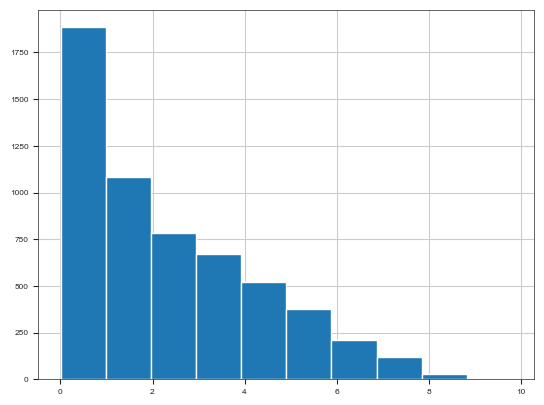

In [16]:
import matplotlib.pyplot as plt
plt.hist(df["sum"])

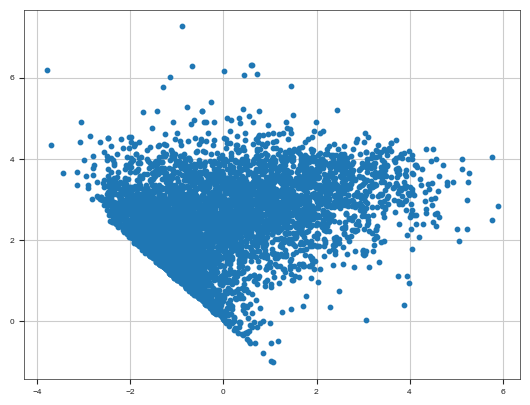

In [18]:
plt.scatter(df["sum"]-df["cLogP"], df["cLogP"])